# Prediction (Inference)

The prediction step can be summarize with the following steps:
* load the **trained model** (`.pth` file) that we generated with the 'Training' notebook,
* select **random images** from the training data set,
* **evaluate** those images with our model so we can check how accurate the prediction goes

In [1]:
import sys

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from torch import nn, optim
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, models, transforms

# Configuration
data_dir = "data_all"
model_file = "trained_model_data_all.pth"
SIZE = 256
classes = None

In [2]:
# Transformations
# These needs to be the same as the Test transformations
# from the 'Training process'
test_transforms = transforms.Compose(
    [
        transforms.Resize((SIZE, SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = torch.load(model_file)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [3]:
# Process to predict a single image, based on the model we load.
def predict_image(image):
    image_tensor = test_transforms(image).float().unsqueeze_(0)
    input_data = Variable(image_tensor).to(device)
    # This is the most important line,
    # since we evaluate the image into our model.
    output = model(input_data)
    return output.data.cpu().numpy().argmax()

# Get 'num' random images from the training data set
def get_random_images(num):
    global classes
    data = datasets.ImageFolder(data_dir, transform=test_transforms)
    classes = data.classes
    indices = list(range(len(data)))
    np.random.shuffle(indices)

    sampler = SubsetRandomSampler(indices[:num])
    dataiter = iter(torch.utils.data.DataLoader(data,
                                                sampler=sampler,
                                                batch_size=num))
    images, labels = dataiter.next()
    return images, labels

# Images result

Since we know the directory of the randomly selected image, we can check if the model evaluation went well or not. This means that we could expect output that look like this:
* **Ok: True**, meaning that the image belongs to 'Ok' and it was *properly classified* in that category by the model,
* **Watering: False**, which means that the image was found on the 'Watering' directory, but the *model didn't predict that category* for the image.

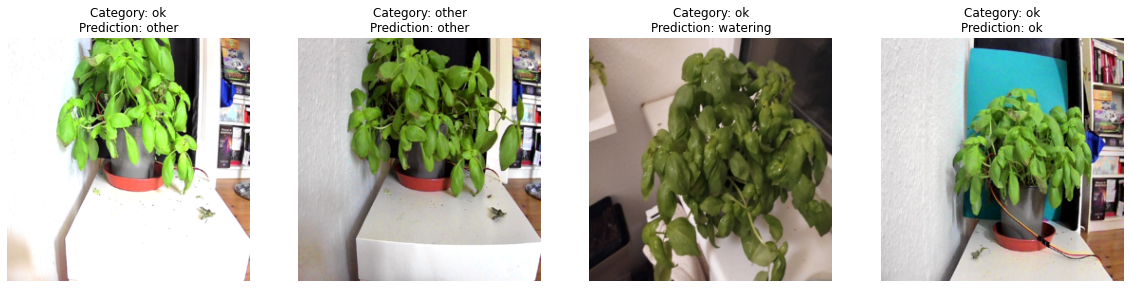

In [4]:
# Displaying images
to_pil = transforms.ToPILImage()
images, labels = get_random_images(4)
category_names = {0: "ok", 1: "other", 2: "watering"}
fig = plt.figure(figsize=(20, 40))

for ii, image in enumerate(images):
    image = to_pil(image)
    index = predict_image(image)

    sub = fig.add_subplot(1, len(images), ii + 1)
    res = int(labels[ii]) == index

    sub.set_title(f"Category: {category_names[int(labels[ii])]}\nPrediction: {classes[index]}")
    plt.axis("off")
    plt.imshow(image)
plt.show()